In [2]:
# import all necesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
import calendar
import plotly as pt
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from pylab import *
import matplotlib.patheffects as PathEffects

import descartes
import geopandas as gpd
from Levenshtein import distance
from itertools import product
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from shapely.geometry import Point, Polygon

import geoplot
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')



In [3]:
chunk_size = 50000  # Adjust the chunk size as needed
chunks = pd.read_csv("D:/Crack/us_Accidents_March23.csv", chunksize=chunk_size)
df = pd.concat(chunks)

In [4]:
# check the no. of columns & rows
print('The Dataset Contains, Rows: {:,d} & Columns: {}'.format(df.shape[0], df.shape[1]))

The Dataset Contains, Rows: 7,728,394 & Columns: 46


In [5]:
# # convert the Start_Time & End_Time Variable into Datetime Feature
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

In [6]:
# create a dataframe of city and their corresponding accident cases
city_df = pd.DataFrame(df['City'].value_counts()).reset_index().rename(columns={"Cases": "City", "count": "Cases"})

In [7]:
city_df.columns

Index(['City', 'Cases'], dtype='object')

In [8]:
top_10_cities = pd.DataFrame(city_df.head(10))
top_10_cities.head

<bound method NDFrame.head of           City   Cases
0        Miami  186917
1      Houston  169609
2  Los Angeles  156491
3    Charlotte  138652
4       Dallas  130939
5      Orlando  109733
6       Austin   97359
7      Raleigh   86079
8    Nashville   72930
9  Baton Rouge   71588>

7728141


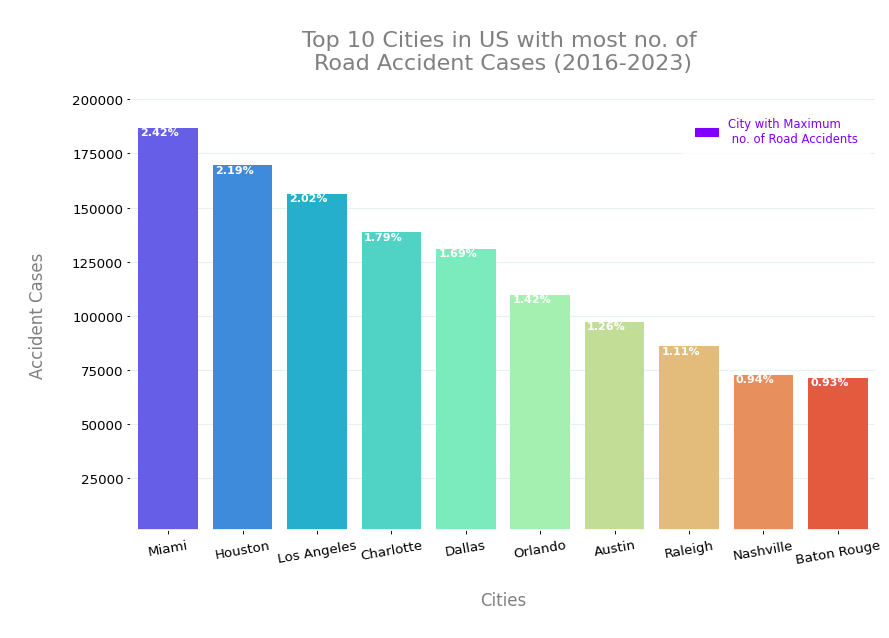

In [9]:
fig, ax = plt.subplots(figsize = (12,7), dpi = 80)

cmap = cm.get_cmap('rainbow', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=top_10_cities['Cases'], x=top_10_cities['City'], palette='rainbow')

total = sum(city_df['Cases'])
print(total)
for i in ax.patches:
    ax.text(i.get_x()+.03, i.get_height()-3500, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10, weight='bold',
                color='white')

plt.title('\nTop 10 Cities in US with most no. of \nRoad Accident Cases (2016-2023)\n', size=20, color='grey')


plt.ylim(1000, 200000)
plt.xticks(rotation=10, fontsize=12)
plt.yticks(fontsize=12)

ax.set_xlabel('\nCities\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['bottom', 'left']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)
MA = mpatches.Patch(color=clrs[0], label='City with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[0], edgecolor='white');
plt.show()

Insights:
1. Los Angeles is the city with highest (2.64%) no. of road accidents in US (2016-2020).

2. Miami is the city with 2nd highest (2.39%) no. of road accidents in US (2016-2020).

3. Around 14% accident records of past 5 years are only from these 10 cities out of 10,657 cities in US (as per the dataset).

In [10]:
hightest_cases = city_df["Cases"][0]
print(round(hightest_cases/5))
print(round(hightest_cases/(5*365)))

37383
102


Insights:
4. In past 5 years (2016-2020) yearly 7,997 road accidents (average) happened in Los Angeles.

5. In Los Angeles averagely in every 12 hours 11 accidents occurred.

In [11]:
def city_cases_percentage(val, operator):
    if operator == '<':
        res = city_df[city_df['Cases']<val].shape[0]
    elif operator == '>':
        res = city_df[city_df['Cases']>val].shape[0]
    elif operator == '=':
        res = city_df[city_df['Cases']==val].shape[0]
    print(f'{res} Cities, {round(res*100/city_df.shape[0], 2)}%')
    
    
city_cases_percentage(1, '=')
city_cases_percentage(100, '<')
city_cases_percentage(1000, '<')
city_cases_percentage(1000, '>')
city_cases_percentage(5000, '>')
city_cases_percentage(10000, '>')

1023 Cities, 7.48%
8947 Cities, 65.41%
12460 Cities, 91.1%
1215 Cities, 8.88%
231 Cities, 1.69%
105 Cities, 0.77%


In this Dataset, we have the records of total 10,657 Cities.

7. 11% (1167 Cities) cities in US, have only 1 accident record in past 5 years.

8. Around 81% (8,682 Cities) of all cities in US, have less than 100 total no. of road accidents.

9. 97.64% (10,406 Cities) cities in US, have the road accident records (2016-2020), less than 1,000.

10. There are 251 Cities (2.36%) in US, which have more than 1,000 total no. of road accidents in past 5 years.

11. 40 Cities (0.38%) in US, have more than 5,000 road accident records.

12. Only 13 Cities (0.12%) in US, have more than 10,000 road accident records.

In [12]:
# create a dictionary using US State code and their corresponding Name
us_states = {'AK': 'Alaska',
 'AL': 'Alabama',
 'AR': 'Arkansas',
 'AS': 'American Samoa',
 'AZ': 'Arizona',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'GU': 'Guam',
 'HI': 'Hawaii',
 'IA': 'Iowa',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'MA': 'Massachusetts',
 'MD': 'Maryland',
 'ME': 'Maine',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MO': 'Missouri',
 'MP': 'Northern Mariana Islands',
 'MS': 'Mississippi',
 'MT': 'Montana',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'NE': 'Nebraska',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NV': 'Nevada',
 'NY': 'New York',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'PR': 'Puerto Rico',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VA': 'Virginia',
 'VI': 'Virgin Islands',
 'VT': 'Vermont',
 'WA': 'Washington',
 'WI': 'Wisconsin',
 'WV': 'West Virginia',
 'WY': 'Wyoming'}

# create a dataframe of State and their corresponding accident cases
state_df = pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'Cases':'State', 'count':'Cases'})


# Function to convert the State Code with the actual corressponding Name
def convert(x): return us_states[x]

state_df['State'] = state_df['State'].apply(convert)


top_ten_states_name = list(state_df['State'].head(10))

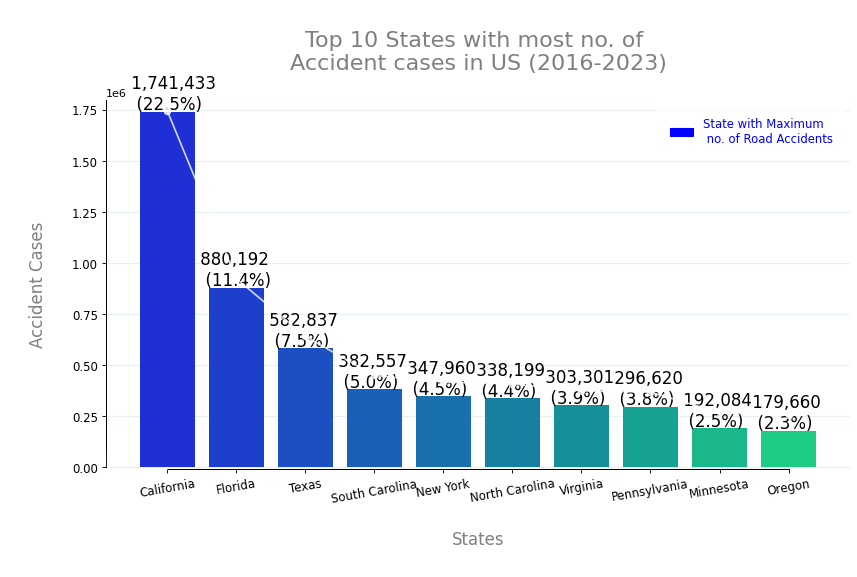

In [13]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 80)

cmap = cm.get_cmap('winter', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=state_df['Cases'].head(10), x=state_df['State'].head(10), palette='winter')
ax1 = ax.twinx()
sns.lineplot(data = state_df[:10], marker='o', x='State', y='Cases', color = 'white', alpha = .8)


total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()-0.2, i.get_height()+10000, \
            ' {:,d}\n  ({}%) '.format(int(i.get_height()), round(100*i.get_height()/total, 1)), fontsize=15,
                color='black')


ax.set(ylim =(-10000, 1800000))
ax1.set(ylim =(-100000, 1800000))

plt.title('\nTop 10 States with most no. of \nAccident cases in US (2016-2023)\n', size=20, color='grey')
ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStates\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['top','right']:
    side1 = ax.spines[i]
    side1.set_visible(False)
    side2 = ax1.spines[i]
    side2.set_visible(False)
    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 1800000)
ax1.spines['bottom'].set_bounds(0.005, 9)
ax1.spines['left'].set_bounds(0, 1800000)
ax.tick_params(axis='y', which='major', labelsize=10.6)
ax.tick_params(axis='x', which='major', labelsize=10.6, rotation=10)

MA = mpatches.Patch(color=clrs[0], label='State with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[0], edgecolor='white');

13. In US, California is the state with highest no. of road accidents in past 5 years.

14. About 30% of the total accident records of past 5 years in US is only from California.

15. In past 5 years, averagely 246 accidents (daily) happened in California implies approximately 10 accidents per hour.

16. Florida is the 2nd highest (10% cases) state for no. road accidents in US.

In [14]:
geometry = [Point(xy) for xy in zip(df['Start_Lng'], df['Start_Lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

geo_df['year'] = geo_df.Start_Time.dt.year

geo_df['State'] = geo_df['State'].apply(convert)

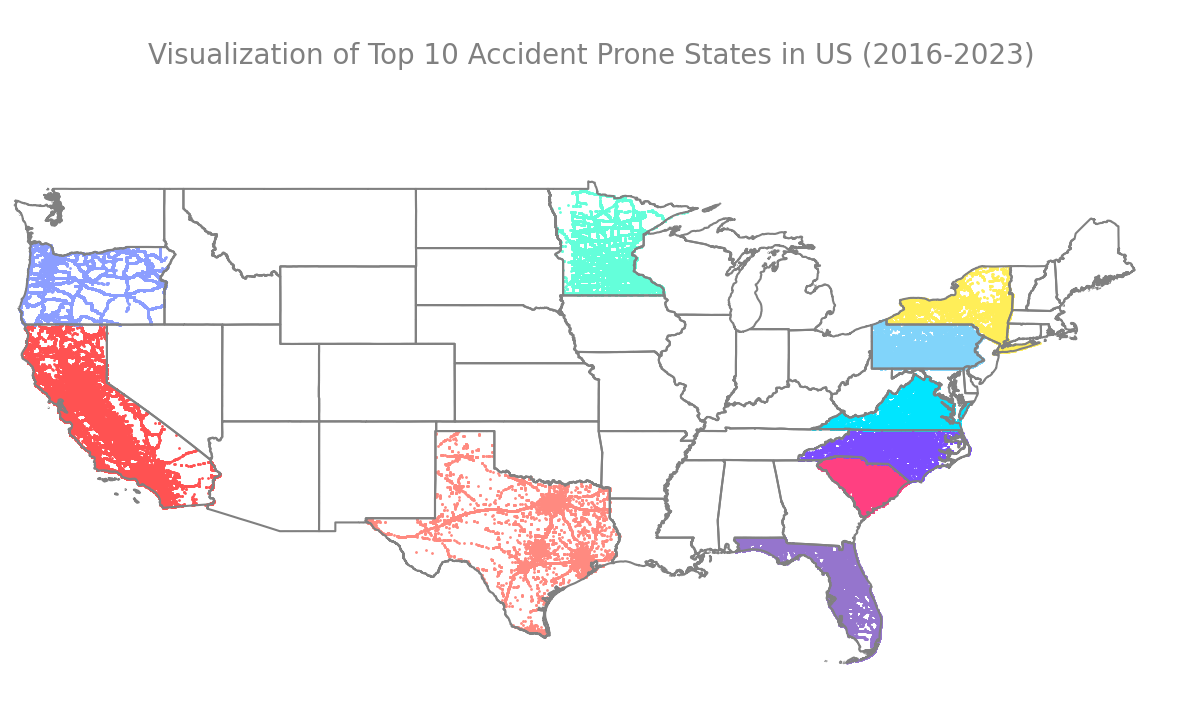

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
states = gpd.read_file('./us-states-map')
states.boundary.plot(ax=ax, color='grey')

# Annotate states from the top ten list
states.apply(lambda x: ax.annotate(text='', xy=x.geometry.centroid.coords[0], ha='center', color='black', weight='bold', fontsize=12.5), axis=1)


# CFOTNYMVNPI
colors = ['#FF5252','#9575CD','#FF8A80','#FF4081','#FFEE58','#7C4DFF','#00E5FF','#81D4FA','#64FFDA','#8C9EFF']
count = 0
for i in list(state_df['State'].head(10)):
    geo_df[geo_df['State'] == i].plot(ax=ax, markersize=1, color=colors[count], marker='o')
    count += 1

# Hide spines and ticks
for i in ['bottom', 'top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

plt.title('\nVisualization of Top 10 Accident Prone States in US (2016-2023)', size=20, color='grey')
plt.show()


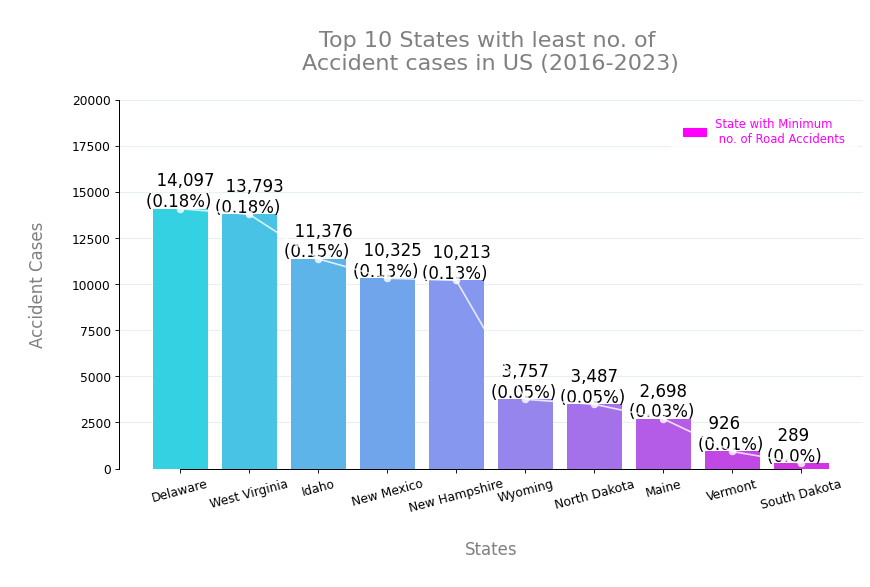

In [16]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 80)

cmap = cm.get_cmap('cool', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=state_df['Cases'].tail(10), x=state_df['State'].tail(10), palette='cool')
ax1 = ax.twinx()
sns.lineplot(data = state_df[-10:], marker='o', x='State', y='Cases', color = 'white', alpha = .8)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()-0.1, i.get_height()+100, \
            '  {:,d}\n({}%) '.format(int(i.get_height()), round(100*i.get_height()/total, 2)), fontsize=15,
                color='black')

ax.set(ylim =(-50, 20000))
ax1.set(ylim =(-50, 20000))

plt.title('\nTop 10 States with least no. of \nAccident cases in US (2016-2023)\n', size=20, color='grey')
ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStates\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    side1 = ax1.spines[i]
    side1.set_visible(False)
    
    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 20000)
ax1.spines['bottom'].set_bounds(0.005, 9)
ax1.spines['left'].set_bounds(0, 20000)
ax.tick_params(axis='y', which='major', labelsize=11)
ax.tick_params(axis='x', which='major', labelsize=11, rotation=15)

MI = mpatches.Patch(color=clrs[-1], label='State with Minimum\n no. of Road Accidents')
ax.legend(handles=[MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[-1], edgecolor='white');

17. South Dakota is the city with lowest no. of road accidents in past 5 years.

18. Only 213 accidents took place in South Dakota in past 5 years implies yearly 42 cases in average.

In [17]:
timezone_df = pd.DataFrame(df['Timezone'].value_counts()).reset_index().rename(columns={'Cases':'Timezone', 'count':'Cases'})

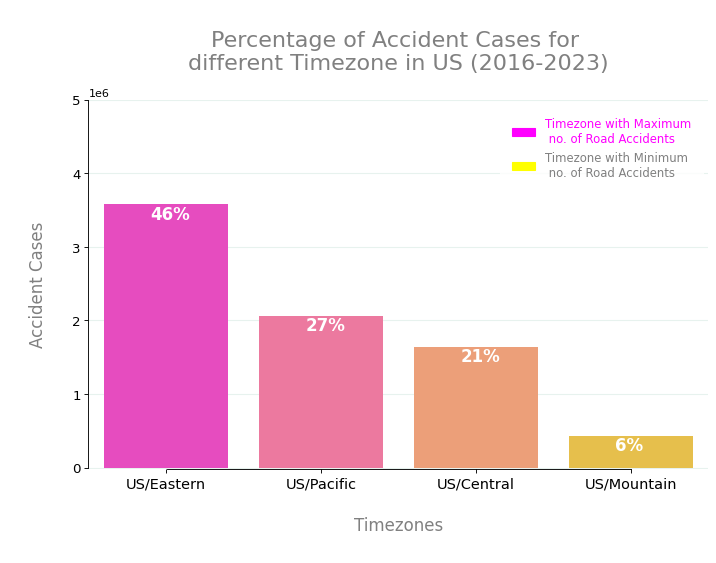

In [18]:
fig, ax = plt.subplots(figsize = (10,6), dpi = 80)

cmap = cm.get_cmap('spring', 4)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=timezone_df['Cases'], x=timezone_df['Timezone'], palette='spring')

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.3, i.get_height()-200000, \
            '{}%'.format(round(i.get_height()*100/total)), fontsize=15,weight='bold',
                color='white')
    

plt.ylim(-20000, 5000000)
plt.title('\nPercentage of Accident Cases for \ndifferent Timezone in US (2016-2023)\n', size=20, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xlabel('\nTimezones\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)
ax.spines['bottom'].set_bounds(0.005, 3)
ax.spines['left'].set_bounds(0, 5000000)

MA = mpatches.Patch(color=clrs[0], label='Timezone with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color=clrs[-1], label='Timezone with Minimum\n no. of Road Accidents')
ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[0], 'grey'], edgecolor='white');

19. Eastern time zone region of US has the highest no. of road accident cases (39%) in past 5 years.

20. Mountain time zone region of US has the lowest no. of road accident cases (6%) in past 5 years.


In [19]:
# create a dataframe of Street and their corresponding accident cases
street_df = pd.DataFrame(df['Street'].value_counts()).reset_index().rename(columns={'Street':'Street No.', 'count':'Cases'})

In [20]:
top_ten_streets_df = pd.DataFrame(street_df.head(10))

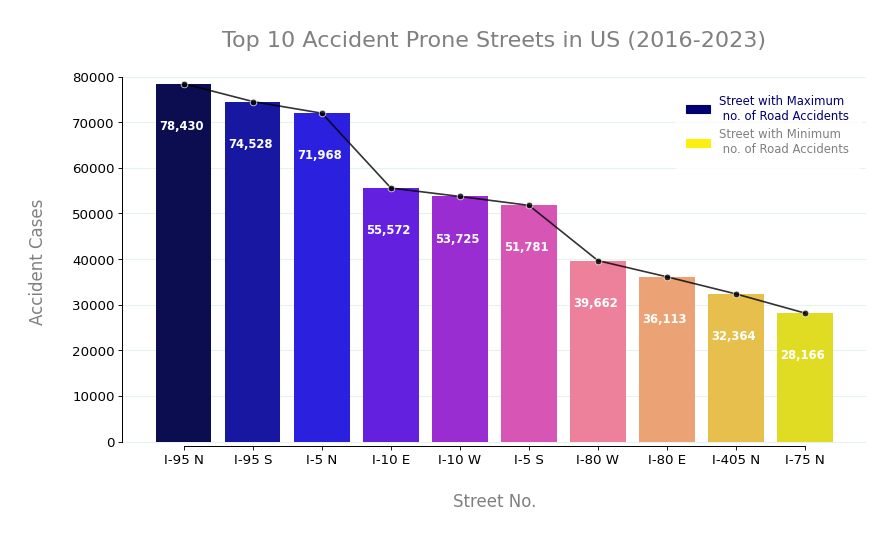

In [21]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 80)
        
cmap = cm.get_cmap('gnuplot2', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=top_ten_streets_df['Cases'], x=top_ten_streets_df['Street No.'], palette='gnuplot2')
ax1 = ax.twinx()
sns.lineplot(data = top_ten_streets_df, marker='o', x='Street No.', y='Cases', color = 'black', alpha = .8)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.04, i.get_height()-10000, \
            '{:,d}'.format(int(i.get_height())), fontsize=10.5,weight='bold',
                color='white')
    
ax.axes.set_ylim(-1000, 80000)
ax1.axes.set_ylim(-1000, 80000)
plt.title('\nTop 10 Accident Prone Streets in US (2016-2023)\n', size=20, color='grey')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nStreet No.\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['top','right']:
    side1 = ax.spines[i]
    side1.set_visible(False)
    side2 = ax1.spines[i]
    side2.set_visible(False)

    
ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

ax.spines['bottom'].set_bounds(0.005, 9)
ax.spines['left'].set_bounds(0, 80000)
ax1.spines['bottom'].set_bounds(0.005, 9)
ax1.spines['left'].set_bounds(0, 80000)
ax.tick_params(axis='both', which='major', labelsize=12)

MA = mpatches.Patch(color=clrs[1], label='Street with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color=clrs[-2], label='Street with Minimum\n no. of Road Accidents')
ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[1], 'grey'], edgecolor='white');

21. In last 5 years (2016-2020) Street No. I-5 N is having the highest road accidents records.

22. In Street No. I-5 N, daily 14 accidents occurred in average.

In [22]:
def street_cases_percentage(val, operator):
    if operator == '=':
        val = street_df[street_df['Cases']==val].shape[0]
    elif operator == '>':
        val = street_df[street_df['Cases']>val].shape[0]
    elif operator == '<':
        val = street_df[street_df['Cases']<val].shape[0]
    print('{:,d} Streets, {}%'.format(val, round(val*100/street_df.shape[0], 2)))
    
    
street_cases_percentage(1, '=')
street_cases_percentage(100, '<')
street_cases_percentage(1000, '<')
street_cases_percentage(1000, '>')
street_cases_percentage(5000, '>')

129,934 Streets, 38.64%
326,421 Streets, 97.06%
335,489 Streets, 99.76%
817 Streets, 0.24%
133 Streets, 0.04%


In Our dataset, there are total 93,048 Streets enlisted for accidental cases,

23. There are 36,441 Streets (39%) in US which have only 1 accident record in past 5 years.

24. 98% Streets of US, have less than 100 road accident cases.

25. Only 0.2% Streets in US have the accident cases greater than 1000.

26. In last 5 years record of road accidents, only 24 Streets (0.03%) have greater than 5000 cases.

# Severity Analysis
It Shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay). Note that severity reported by different sources may differ in their underlying impact on traffic, so please separate data from different sources when doing severity-based analysis.

In [23]:
# create a dataframe of Severity and the corresponding accident cases
severity_df = pd.DataFrame(df['Severity'].value_counts()).rename(columns={'Severity':'Severity', 'count':'Cases'})

In [24]:
fig = go.Figure(go.Funnelarea(
    text = ["Severity - 2","Severity - 3", "Severity - 4", "Severity - 1"],
    values = severity_df.Cases,
    title = {"position": "top center", 
             "text": "<b>Impact on the Traffic due to the Accidents</b>", 
             'font':dict(size=18,color="#7f7f7f")},
    marker = {"colors": ['#14a3ee', '#b4e6ee', '#fdf4b8', '#ff4f4e'],
                "line": {"color": ["#e8e8e8", "wheat", "wheat", "wheat"], "width": [7, 0, 0, 2]}}
    ))

fig.write_html('plot.html')


27. In 80% Cases of road accidents, the impact on the traffic was Moderate (Severity-2).

28. In 7.5% Cases of road accidents, the impact on the traffic was highly Severe (Severity-4).

# Time Analysis
In this dataset we have Start_Time & End_Time for the timings of each accident. Start_Time shows start time of the accident in local time zone. End_Time shows end time of the accident in local time zone. End time here refers to when the impact of accident on traffic flow.

# Accident Duration Analysis

In [25]:
accident_duration_df = pd.DataFrame(df['End_Time'] - df['Start_Time']).reset_index().rename(columns={'index':'Id', 0:'Duration'})

In [26]:
accident_duration_df.columns

Index(['Id', 'Duration'], dtype='object')

In [27]:
top_10_accident_duration_df = pd.DataFrame(accident_duration_df['Duration'].value_counts().head(10).sample(frac = 1)).reset_index().rename(columns={'Duration':'Duration', 'count':'Cases'})

Duration = [str(i).split('days')[-1].strip() for i in top_10_accident_duration_df.Duration]

top_10_accident_duration_df['Duration'] = Duration

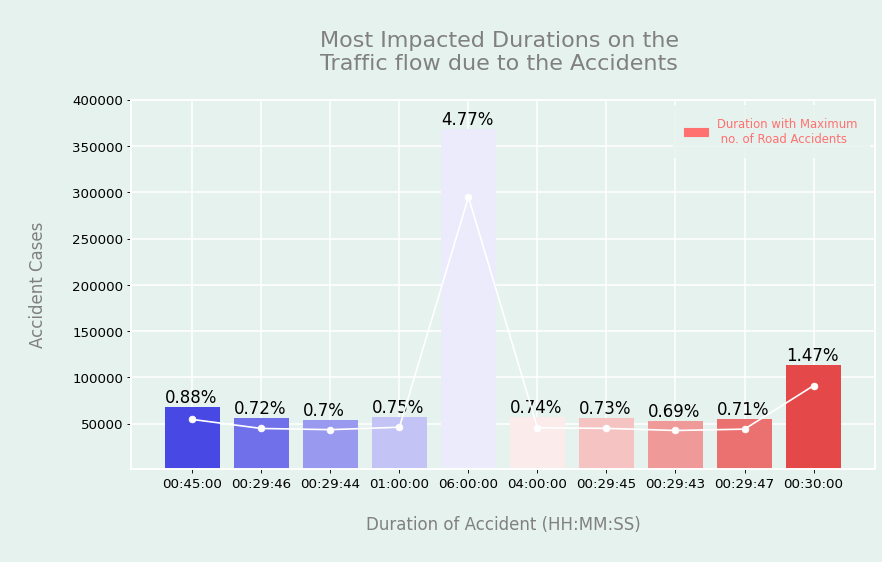

In [28]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 80)
ax.set_facecolor('#e6f2ed')
fig.patch.set_facecolor('#e6f2ed')

cmap = cm.get_cmap('bwr', 10)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(y=top_10_accident_duration_df['Cases'], x=top_10_accident_duration_df['Duration'], palette='bwr')
ax1 = ax.twinx()
sns.lineplot(data = top_10_accident_duration_df, marker='o', x='Duration', y='Cases', color = 'white', alpha = 1)

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+5000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='black')

ax.set(ylim =(1000, 400000))
ax1.set(ylim =(1000, 500000))

plt.title('\nMost Impacted Durations on the \nTraffic flow due to the Accidents \n', size=20, color='grey')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nDuration of Accident (HH:MM:SS)\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)
    
ax.set_axisbelow(True)
ax.grid(color='white', linewidth=1.5)
ax.tick_params(axis='both', which='major', labelsize=12)
MA = mpatches.Patch(color=clrs[-3], label='Duration with Maximum\n no. of Road Accidents')
ax.legend(handles=[MA], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=clrs[-3], facecolor='#e6f2ed', edgecolor='#e6f2ed');

29. From the above plot, it is inferred that majority (24.25%) of road accidents, have impacted on the traffic flow for 6 hours.

In [29]:
year_df = pd.DataFrame(df.Start_Time.dt.year.value_counts()).reset_index().rename(columns={'Start_Time':'Year', 'count':'Cases'}).sort_values(by='Cases', ascending=True)

In [30]:
year_df.columns

Index(['Year', 'Cases'], dtype='object')

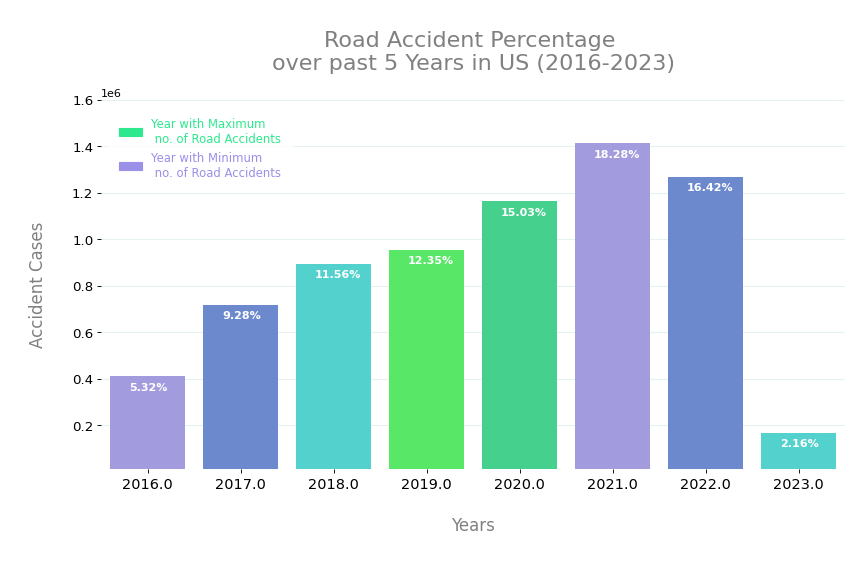

In [31]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 80)

ax=sns.barplot(y=year_df['Cases'], x=year_df['Year'], palette=['#9a90e8', '#5d82de', '#3ee6e0', '#40ff53','#2ee88e'])

total = df.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()-60000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10,weight='bold',
                color='white')

plt.ylim(10000, 1600000)
plt.title('\nRoad Accident Percentage \nover past 5 Years in US (2016-2023)\n', size=20, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xlabel('\nYears\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    

for k in ['top', 'right', "bottom", 'left']:
        side = ax.spines[k]
        side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=0.3)
MA = mpatches.Patch(color='#2ee88e', label='Year with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color='#9a90e8', label='Year with Minimum\n no. of Road Accidents')
ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=['#2ee88e', '#9a90e8'], edgecolor='white');
plt.show()

30. From the above figure, it is clear that in last 5 years (2016-2020) in US accidents percentage has increased significantly.

31. 70% of the total road accident records of last 5 years happened only within last 2 years (2019, 2020).

In [32]:
accident_severity_df = geo_df.groupby(['year', 'Severity']).size().unstack()

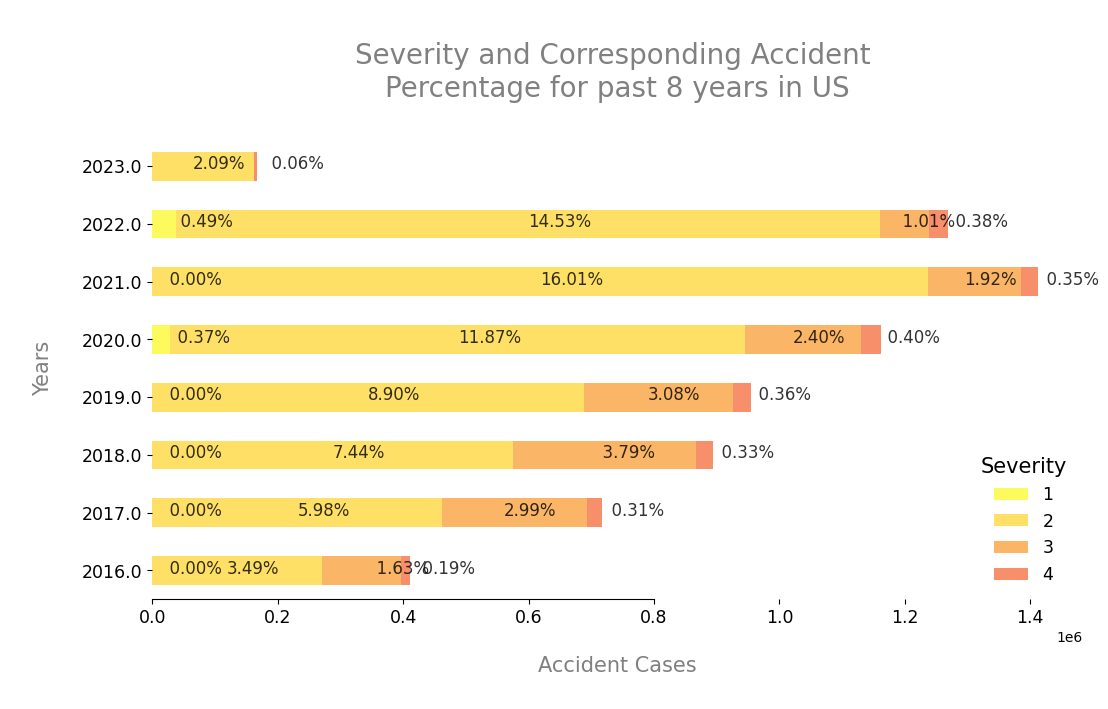

In [33]:
ax = accident_severity_df.plot(kind='barh', stacked=True, figsize=(12, 6), 
                               color=['#fcfa5d', '#ffe066', '#fab666', '#f68f6a'],
                               rot=0);

ax.set_title('\nSeverity and Corresponding Accident \nPercentage for past 8 years in US\n', fontsize=20, color='grey');

for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
    
ax.spines['bottom'].set_bounds(0, 800000);
ax.set_ylabel('\nYears\n', fontsize=15, color='grey');
ax.set_xlabel('\nAccident Cases\n', fontsize=15, color='grey');
ax.legend(prop={'size': 12.5}, loc='best', fancybox = True, title="Severity", title_fontsize=15, edgecolor='white');
ax.tick_params(axis='both', which='major', labelsize=12.5)
#ax.set_facecolor('#e6f2ed')
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    var = width*100/df.shape[0]
    if var > 0:
        if var > 4:
            ax.text(x+width/2, 
                        y+height/2-0.05, 
                        '{:.2f}%'.format(width*100/df.shape[0]),
                        fontsize=12,  color='black', alpha= 0.8)
        elif var > 1.8 and var < 3.5:
            ax.text(x+width/2-17000, 
                        y+height/2-0.05, 
                        '{:.2f}%'.format(width*100/df.shape[0]),
                        fontsize=12,  color='black', alpha= 0.8)      
        elif var>1.5 and var<1.8:
            ax.text(x+width/2+7000, 
                    y+height/2-0.05, 
                    '  {:.2f}%'.format(width*100/df.shape[0]),
                    fontsize=12,  color='black', alpha= 0.8)
        elif var>1:
            ax.text(x+width/2-20000, 
                    y+height/2-0.05, 
                    '  {:.2f}%'.format(width*100/df.shape[0]),
                    fontsize=12,  color='black', alpha= 0.8)
        else:
            ax.text(x+width/2+10000, 
                    y+height/2-0.05, 
                    '  {:.2f}%'.format(width*100/df.shape[0]),
                    fontsize=12,  color='black', alpha= 0.8)

32. In last 4 years (2017-2020) highly severe (Severity-4) accident cases in us remain in the range of 1.55% to 1.8%.

33. 45% of the total road accidents of last 5 years which occurred only in 2020 are moderately severe (Severity-2).

In [34]:
year_df['accident/day'] = round(year_df['Cases']/(5*365))
year_df['accident/hour'] = round(year_df['Cases']/(5*365*24))

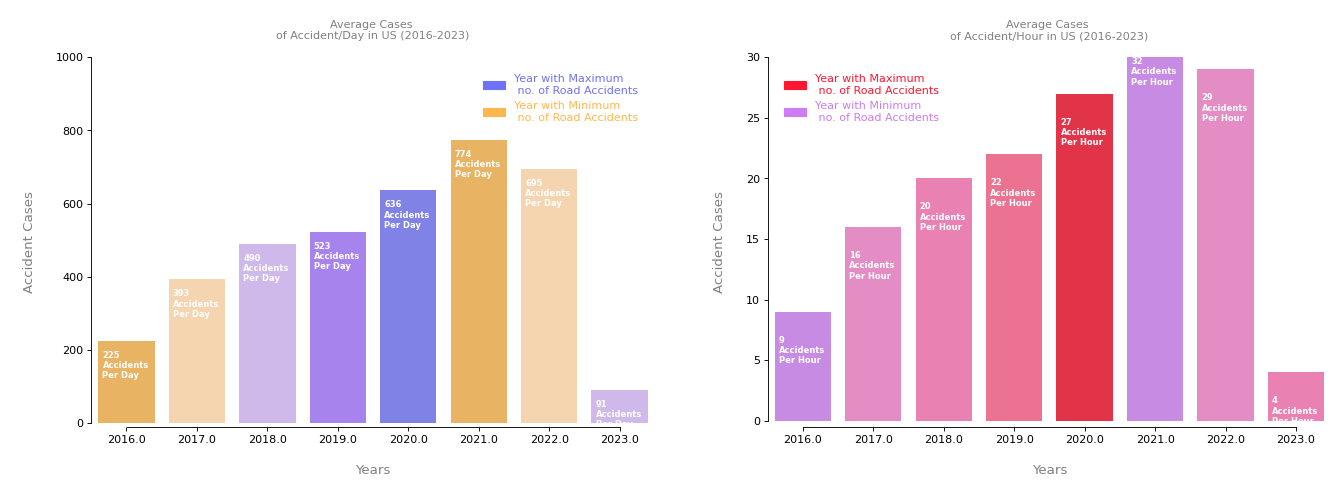

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6), dpi = 80)

count = 0
plots = ['accident/day', 'accident/hour']
plots_limit = [(-10, 1000), (-0.5, 30)]
plots_bound = [(0, 1000), (0, 30)]
plot_text = [60, 2.5]

colors = [['#ffb74b', '#ffd6a4', '#ceb1f2', '#a071ff', '#6f71f7'], 
          ['#cd7cf2', '#f27ec8', '#fa70b3', '#ff5e86', '#ff1732']]

for i in [ax1, ax2]:

    sns.barplot(ax=i, y=year_df[plots[count]], x=year_df['Year'], palette=colors[count])
    
    var = plots[count].split('/')[-1].capitalize()
    
    for j in i.patches:
        i.text(j.get_x()+0.06, j.get_height()-plot_text[count]*1.7, \
                str(int(j.get_height()))+'\nAccidents\nPer {}'.format(var), fontsize=7.5, color='white', weight='bold')

    i.axes.set_ylim(plots_limit[count])
    i.axes.set_ylabel('\nAccident Cases\n', fontsize=12, color='grey')
    i.axes.set_xlabel('\nYears\n', fontsize=12, color='grey')
    i.tick_params(axis='both', which='major', labelsize=10)

    i.set_title('\nAverage Cases \nof Accident/{} in US (2016-2023)\n'.format(var), fontsize =10, color='grey')
    i.spines['bottom'].set_bounds(0.005, 7)
    i.spines['left'].set_bounds(plots_bound[count])

    for k in ['top', 'right']:
            side = i.spines[k]
            side.set_visible(False)

    i.set_axisbelow(True)
    MA = mpatches.Patch(color=colors[count][-1], label='Year with Maximum\n no. of Road Accidents')
    MI = mpatches.Patch(color=colors[count][0], label='Year with Minimum\n no. of Road Accidents')
    i.legend(handles=[MA, MI], prop={'size': 10}, loc='best', borderpad=1, 
          labelcolor=[colors[count][-1], colors[count][0]], edgecolor='white');
    count += 1


34. In the year 2020, averagely 432 accidents happened per day in US.

35. From 2019 to 2020 the average accident/day has increased 3 times in US.

36. Compare to 2016 the accident/hour has increased 6 times in 2020.

37. In the year 2020, averagely 18 accidents happened per hour in US implies that 3 accidents in every 10 minutes.

In [36]:
month_df = pd.DataFrame(df.Start_Time.dt.month.value_counts()).reset_index().rename(columns={'Start_Time':'Month', 'count':'Cases'}).sort_values('Month')

month_names = list(calendar.month_name)[1:]
month_df.Month = month_names

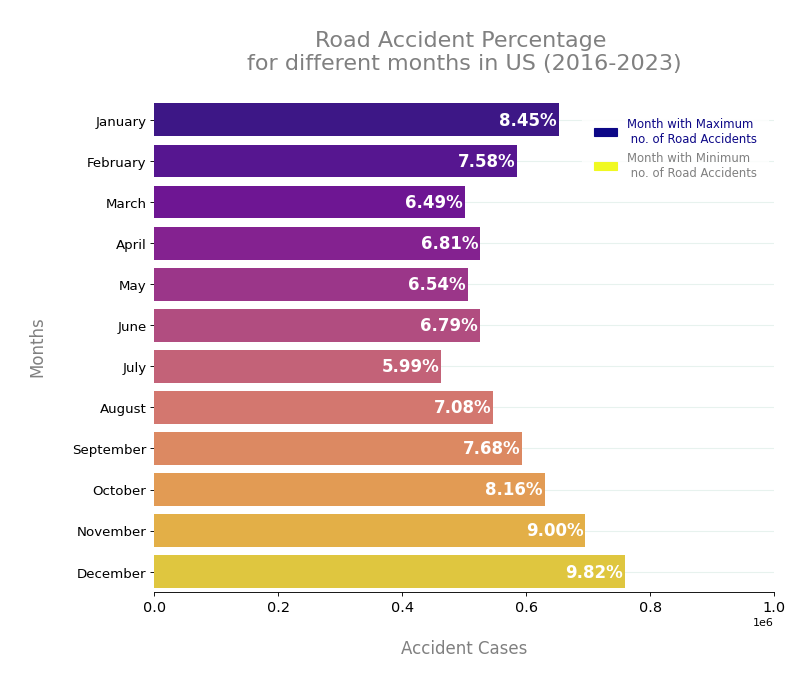

In [37]:
fig, ax = plt.subplots(figsize = (10,8), dpi = 80)

cmap = cm.get_cmap('plasma', 12)   
clrs = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]

ax=sns.barplot(x=month_df['Cases'], y=month_df['Month'], palette='plasma')

total = df.shape[0]
for p in ax.patches:
    plt.text(p.get_width()-50000, p.get_y()+0.4,
            '{:.2f}%'.format(p.get_width()*100/total),ha='center', va='center', fontsize=15, color='white', weight='bold')

plt.title('\nRoad Accident Percentage \nfor different months in US (2016-2023)\n', size=20, color='grey')
plt.xlabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.ylabel('\nMonths\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xlim(0, 1000000)

for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0, 1000000)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=.3)

MA = mpatches.Patch(color=clrs[0], label='Month with Maximum\n no. of Road Accidents')
MI = mpatches.Patch(color=clrs[-1], label='Month with Minimum\n no. of Road Accidents')

ax.legend(handles=[MA, MI], prop={'size': 10.5}, loc='best', borderpad=1, 
          labelcolor=[clrs[0], 'grey'], edgecolor='white');

38. Around 18% of the road accidents occurred in the month of December.

39. July is month with least (3.54%) no. of road accidents in US.

40. 45% of the road accidents occurred only within the 3 months, October to December (i.e., transition period from Autumn to Winter).